# regression decoder test (~10/6/22)
this compares a fixed decoder, pca decoder, cca transformation (w/ day0 decoder), and a regression decoder on day-N data. the latter two use a day-0 data as a prior start. 

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.cca_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
from src.utils import *
import pickle
import scipy as sio
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import os
import copy

# set paths/create objects

cp1 = day-0

cp2 = day-n


# pathdump:

N5 
cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N5/N5_170929_No Obstacles_s.mat'
cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N5/N5_171001_No Obstacles_s.mat'
'N5_171016_No Obstacles_s.mat'
'N5_171130_No Obstacles_s.mat'

n6
'N6_171026_No Obstacles_s.mat' this day has pretty low %vaf max
'N6_171204_No Obstacles_s.mat'
'N6_171211_No Obstacles_s.mat'

n9
cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N9/N9_171121_No Obstacles_s.mat'
cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N9/N9_171204_No Obstacles_s.mat'
'N9_171211_No Obstacles_s.mat'  'N9_171214_No Obstacles_s.mat

In [2]:
cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N6/N6_171026_No Obstacles_s.mat'
cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N6/N6_171204_No Obstacles_s.mat'

cp1 = CortProcessor(cp1_path)
cp2 = CortProcessor(cp2_path)

this is filipe data i belive
this is filipe data i belive


In [3]:
#subsampling list, percent of total data
subsample_list = [.01, .05, .1, .5, 1.0]
nummy = cp2.data['rates'][0].shape[0]
newlist = [int(sub * nummy) for sub in subsample_list]

print(f'num_samples:{newlist}')

num_samples:[120, 601, 1202, 6011, 12023]


In [4]:
lowest_num_dimensions=8

# getting day0 decoder
apply PCA (based on all data), and then train wiener filter.
also get a day0-scaled-weights-decoder

In [5]:
#get day0 decoder weights, scaled + unscaled versions

day0_decoder, nada, naday, nadax = cp1.decode_angles(X=cp1.apply_PCA(dims=lowest_num_dimensions))
#lowest_num_dimensions = cp1.num_components
print(np.average(nada, 1)[1])

X_tempy =cp1.apply_PCA(lowest_num_dimensions)
scaler = StandardScaler()
X_scale = scaler.fit_transform(np.squeeze(X_tempy))
day0_decoder_scale, nada, naday, nadax = cp1.decode_angles(X=[X_scale])

print(np.average(nada, 1)[1])

0.262
0.262


# getting fixed decoder scores
1) we subsample Day-N data, and fit PCA transformation. 
2) we transform entire Day-N data, and decode using Day0 decoder.

# getting PCA decoder scores
1) we subsample Day-N data, fit PCA transformation, and then transform it. 
2) We train new PCA decoder on only this low-D subsampled data
3) We transform entire Day-N data, and decode using this new PCA decoder. 


In [6]:
fixed_decoder_scores = []
pca_decoder_scores = []
pca_predic=[]

for i in range(len(subsample_list)):
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    #apply PCA just using subsampled data
    sub_x_pca = cp2.apply_PCA(dims=lowest_num_dimensions, X=sub_x)
    #save PCA transformation
    pca_object = cp2.pca_object
    #train PCA decoder 
    temp_h, nada, nadax, naday = cp2.decode_angles(X=sub_x_pca, Y=sub_y)
    
    test_x = np.squeeze(np.array(cp2.apply_PCA(dims=lowest_num_dimensions, transformer = pca_object)))
    test_y = np.squeeze(np.array(cp2.data['angles']))
    
    test_x_format, test_y_format = format_data(test_x, test_y)
    
    temp_y = test_wiener_filter(test_x_format, day0_decoder)
    fixed_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    
    temp_y = test_wiener_filter(test_x_format, temp_h)
    pca_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    
    pca_predic.append(temp_y)

print(fixed_decoder_scores)
print(pca_decoder_scores)

[0.22, 0.14, 0.16, 0.21, 0.21]
[-0.08, 0.37, 0.52, 0.59, 0.6]


# cca decoder

1) We subsample Day-N data
2) We align Day-N subsampled data to Day-0 data
3) We fit PCA transformation on subsampled Day-n data, and then transform it
4) We fit a CCA transformation on subsampled, low-D day-N data
5) We apply our PCA transformation to entire Day-N, and then apply our CCA transformation to entire low-D day-N data
6) We decode this using Day-0 decoder.

In [7]:
cca_decoder_scores = []
cca_transformers=[]
for i in range(len(subsample_list)):
    #make subsampled cp2
    temp_cp2 = copy.deepcopy(cp2)
    sub_x2, sub_y2 = temp_cp2.subsample(percent = subsample_list[i])
    
    temp_cp2.data['rates'] = sub_x2
    temp_cp2.data['angles'] = sub_y2
    
    temp_cca = CCAProcessor(cp1, temp_cp2)
    
    pca_sub_x1, pca_sub_x2 = temp_cca.apply_PCA(preset_num_components=lowest_num_dimensions)
    temp_cca_transformer, nada = temp_cca.apply_CCA(preset_num_components = lowest_num_dimensions)
    
    cca_transformers.append(temp_cca_transformer)
    
    test_x = np.squeeze(np.array(cp2.apply_PCA(dims=lowest_num_dimensions, transformer = temp_cca.data['cp2']['pca_transformer'])))
    test_y = np.squeeze(np.array(cp2.data['angles']))
    
    nada, test_x_cca_space = temp_cca_transformer.transform(test_x, test_x)
    
    temp_x = temp_cca_transformer.inverse_transform(test_x_cca_space)
    
    temp_x_format, test_y_format = format_data(temp_x, test_y)
    predic = test_wiener_filter(temp_x_format, day0_decoder)
    
    cca_decoder_scores.append(vaf(test_y_format[:,1], predic[:,1]))

should be good to align
(101, 28)
(101, 5)
(101, 21)
(101, 5)
should be good to align
(303, 28)
(303, 5)
(303, 21)
(303, 5)
should be good to align
(638, 28)
(638, 5)
(638, 21)
(638, 5)
should be good to align
(3120, 28)
(3120, 5)
(3120, 21)
(3120, 5)
should be good to align
(5590, 28)
(5590, 5)
(5590, 21)
(5590, 5)


In [8]:
cca_decoder_scores

[-0.11, 0.19, 0.22, 0.19, 0.2]

# regression fit
1) We subsample day-n data, fit PCA transformation, and then transform it
2) We then transform it using CCA transformation corresponding to same subsample we got in the CCA part. 
3) We scale it. #TODO try using day0 scale to transform it
4) We feed this subsampled, low-d, CCA-transformed day-n data into our regression decoder. It spits out a new decoder.
5) We take entire Day-N data, transform it with both PCA/CCA corresponding to subsample, scale it, and then decode using our new decoder

In [9]:
r_scores = []
r_predic=[]

for i in range(len(subsample_list)):
    #subsample day-n unprocessed data
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    
    #apply PCA to subsampled data
    sub_x_pca = np.squeeze(cp2.apply_PCA(dims=lowest_num_dimensions, X=sub_x))
    #transform PCA subsample to day-0 shape
    nada, sub_x_cca_space = cca_transformers[i].transform(sub_x_pca, sub_x_pca)
    temp_x = cca_transformers[i].inverse_transform(sub_x_cca_space)
    #scale transformed data 
    scaler = StandardScaler()
    temp_x_scale = scaler.fit_transform(temp_x)

    wpost = ridge_fit(b0=day0_decoder_scale, x=temp_x_scale, y=np.squeeze(sub_y), my_alpha=100.0)
    
    
    ###now lets test on full dataset
    test_x = np.squeeze(np.array(cp2.apply_PCA(dims=lowest_num_dimensions, transformer = cp2.pca_object)))
    test_y = np.squeeze(np.array(cp2.data['angles']))
    
    nada, test_xx = temp_cca.apply_CCA(cp2_x = test_x, transformer = cca_transformers[i])
    test_xx_scale = scaler.transform(test_xx)
    test_xx_scale_format, nada = format_data(test_xx_scale, test_y)
    temp_y = test_wiener_filter(test_xx_scale_format, wpost)
    
    r_predic.append(temp_y)  
    predic = vaf(test_y_format[:,1], temp_y[:,1])
    
 
    r_scores.append(predic)

initial_scoring is : -0.2
new_scoring is: 0.76
initial_scoring is : 0.18
new_scoring is: 0.51
initial_scoring is : 0.24
new_scoring is: 0.52
initial_scoring is : 0.22
new_scoring is: 0.57
initial_scoring is : 0.24
new_scoring is: 0.6


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
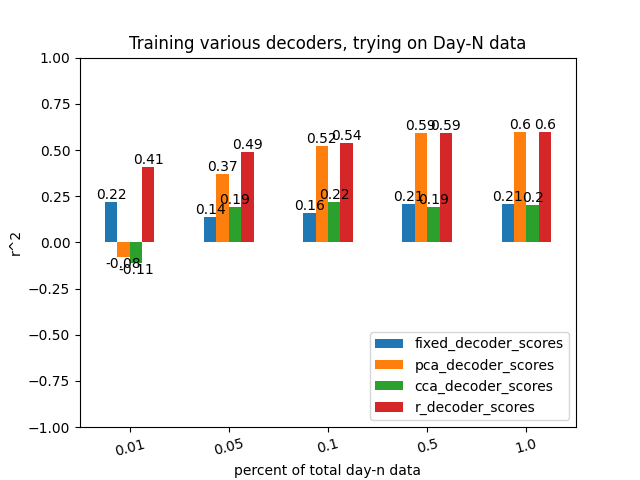

In [10]:
%matplotlib widget
%matplotlib widget

plot_dict = {}
plot_dict['fixed_decoder_scores'] = fixed_decoder_scores
plot_dict['pca_decoder_scores'] = pca_decoder_scores
plot_dict['cca_decoder_scores'] = cca_decoder_scores
plot_dict['r_decoder_scores'] = r_scores

index = subsample_list

df = pd.DataFrame(data=plot_dict, index=index)

  
# plot grouped bar chart
ax = df.plot.bar(rot=15)
ax.set_ylim(bottom=-1, top=1)
ax.set_title('Training various decoders, trying on Day-N data')
ax.set_ylabel('r^2')
ax.set_xlabel('percent of total day-n data')
ax.legend(loc='lower right')
for container in ax.containers:
    ax.bar_label(container)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
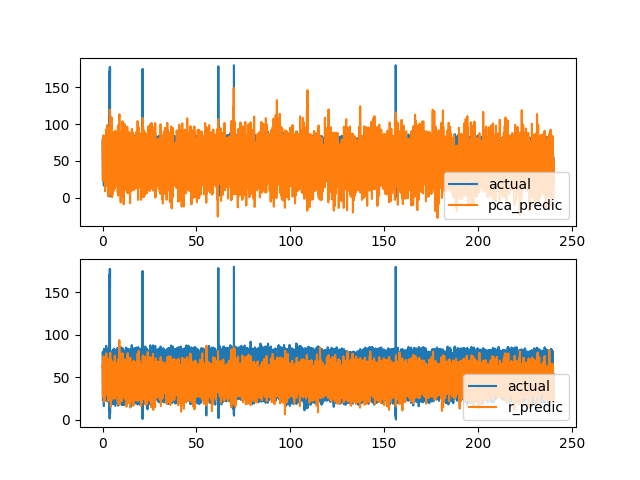

In [11]:
fig0 = plt.figure()
ax0 = fig0.add_subplot(211)
ts = np.arange(0, test_y_format.shape[0]/50, 1/50)

num =0 

legend1=['actual', 'pca_predic']
legend2=['actual','r_predic']


ax0.plot(ts, test_y_format[:,1])
ax0.plot(ts, pca_predic[num][:,1])
ax0.legend(legend1, loc='lower right')

ax01 = fig0.add_subplot(212, sharex=ax0)
ax01.plot(ts, test_y_format[:,1])
ax01.plot(ts, r_predic[num][:,1])
ax01.legend(legend2, loc='lower right')

# notes

cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N5/N5_171016_No Obstacles_s.mat'
cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N6/N6_171204_No Obstacles_s.mat'

with these two, regression is good vaf score but in practicality something seems off!



# paths

N5 
cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N5/N5_170929_No Obstacles_s.mat'
cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N5/N5_171001_No Obstacles_s.mat'
'N5_171016_No Obstacles_s.mat'
'N5_171130_No Obstacles_s.mat'

n6
'N6_171026_No Obstacles_s.mat'
'N6_171204_No Obstacles_s.mat'
'N6_171211_No Obstacles_s.mat'

n9
'N9_171121_No Obstacles_s.mat'  'N9_171204_No Obstacles_s.mat'  'N9_171211_No Obstacles_s.mat'  'N9_171214_No Obstacles_s.mat